# Import packages

In [96]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Load evaluation score

In [34]:
def load_json(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [76]:
def get_path(model_nickname, from_epoch, to_epoch, label, idx):
    return f'/raid/NeuEvo/data/eval_important_evo/{model_nickname}/data/eval_evo-from={model_nickname}_{from_epoch}-to={model_nickname}_{to_epoch}-label={label}-num_bins=4-num_sampled_imgs=250-idx={idx}.json'

def load_eval(model_nickname, from_epoch, to_epoch, label, idx):
    p = get_path(model_nickname, from_epoch, to_epoch, label, idx)
    data = load_json(p)
    return data

# Aggregate evaluation score

In [132]:
def aggregate_eval_score(model_nickname, from_epoch, to_epoch, labels):
    # Initialize aggregated data
    agg_data_all_labels = {
        'train': {
            'important': {'top1': [0, 0, 0, 0], 'topk': [0, 0, 0, 0]},
            'random': {'top1': 0, 'topk': 0},
            'to': {'top1': 0, 'topk': 0}
        },
        'test': {
            'important': {'top1': [0, 0, 0, 0], 'topk': [0, 0, 0, 0]},
            'random': {'top1': 0, 'topk': 0},
            'to': {'top1': 0, 'topk': 0}
        }
    }
    
    # Aggregate over labels
    for label in labels:
        
        # Initialize aggregated data
        agg_data = {
            'train': {
                'important': {'top1': [0, 0, 0, 0], 'topk': [0, 0, 0, 0]},
                'random': {'top1': 0, 'topk': 0},
                'to': {'top1': 0, 'topk': 0}
            },
            'test': {
                'important': {'top1': [0, 0, 0, 0], 'topk': [0, 0, 0, 0]},
                'random': {'top1': 0, 'topk': 0},
                'to': {'top1': 0, 'topk': 0}
            }
        }

        # Aggregate over 5 independent runs
        for idx in range(5):
            # print(model_nickname, from_epoch, to_epoch, label, idx)
            d = load_eval(model_nickname, from_epoch, to_epoch, label, idx)
            
            for t in ['train', 'test']:
                # Accuracy at to_epoch
                top1_d = d[t]['to']['top1']
                topk_d = d[t]['to']['topk']
                to = {
                    'top1': top1_d['correct'] / (top1_d['correct'] + top1_d['incorrect']),
                    'topk': topk_d['correct'] / (topk_d['correct'] + topk_d['incorrect']),
                }
                # print(to)

                # Accuracy drops when important neurons reverted
                layers = list(d[t]['important'].keys())
                drop = {
                    'top1': [0, 0, 0, 0],
                    'topk': [0, 0, 0, 0]
                }
                for k in ['top1', 'topk']:
                    for i in range(4):
                        for layer in layers[:-1]:
                            dd = d[t]['important'][layer][k]
                            acc = dd['correct'][i] / (dd['correct'][i] + dd['incorrect'][i])
                            drop[k][i] += acc - to[k]
                        drop[k][i] /= (len(layers) - 1)

                # Accuracy drops when random neurons reverted
                rand_drop = {'top1': 0, 'topk': 0}
                for k in ['top1', 'topk']:
                    for layer in layers[:-1]:
                        dd = d[t]['random'][layer][k]
                        acc = dd['correct'] / (dd['correct'] + dd['incorrect'])
                        rand_drop[k] += acc - to[k]
                    rand_drop[k] /= (len(layers) - 1)

                # Aggregate the values
                for k in ['top1', 'topk']:
                    for i in range(4):
                        agg_data[t]['important'][k][i] += drop[k][i]
                    agg_data[t]['random'][k] += rand_drop[k]
                    agg_data[t]['to'][k] += to[k]

        # Average the values
        for t in ['train', 'test']:
            for k in ['top1', 'topk']:
                for i in range(4):
                    agg_data[t]['important'][k][i] /= 5
                agg_data[t]['random'][k] /= 5
                agg_data[t]['to'][k] /= 5
            # print(agg_data[t])
            # asdf
        
        # Aggregate over labels
        for t in ['train', 'test']:
            for k in ['top1', 'topk']:
                for i in range(4):
                    agg_data_all_labels[t]['important'][k][i] += agg_data[t]['important'][k][i]
                agg_data_all_labels[t]['random'][k] += agg_data[t]['random'][k]
                agg_data_all_labels[t]['to'][k] += agg_data[t]['to'][k]
                
    # Average the values
    for t in ['train', 'test']:
        for k in ['top1', 'topk']:
            for i in range(4):
                agg_data_all_labels[t]['important'][k][i] /= len(labels)
            agg_data_all_labels[t]['random'][k] /= len(labels)
            agg_data_all_labels[t]['to'][k] /= len(labels)

    return agg_data_all_labels

def draw_and_save_plot(data, model_nickname, from_epoch, to_epoch, out_dir):
    labels = ['0-25', '25-50', '50-75', '75-100']
    
    for t in ['train', 'test']:
        for k in ['top1', 'topk']:
            file_path = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}-{t}-{k}.pdf')
            r = data[t]['random'][k]
            to = data[t]['to'][k]
            plt.title(f'{t} acc {k}, rand={r:.3f}, to={to:.3f}')
            plt.bar(labels, data[t]['important'][k])
            plt.axhline(y=r, color='black')
            plt.xlabel('importance percentile')
            plt.ylabel('acc drop')
            plt.savefig(file_path)
            plt.show()

# Save results

In [133]:
out_dir = '/raid/NeuEvo/data/fig/eval/'
labels = [1, 10, 11, 20, 27, 34, 42, 48, 53, 59, 67, 85, 97, 104, 133, 156, 159, 175, 230, 242, 262, 263, 268, 273, 277, 280, 282, 286, 301, 304, 315, 324, 346, 353, 371, 378, 384, 388, 394, 400, 406, 415, 435, 436, 446, 457, 469, 475, 481, 494, 500, 513, 514, 520, 524, 538, 548, 553, 555, 578, 582, 592, 622, 638, 658, 663, 690, 694, 703, 707, 712, 721, 732, 735, 758, 762, 789, 800, 801, 819, 830, 842, 856, 857, 867, 897, 903, 906, 910, 913, 943, 944, 957, 963, 964, 972, 975, 979, 993, 994]

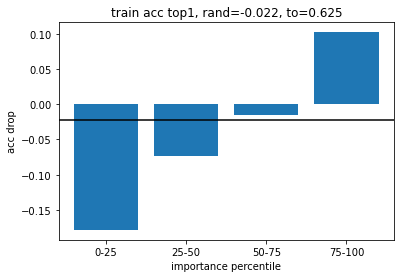

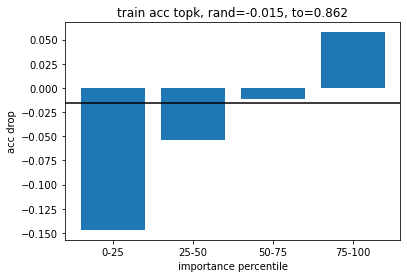

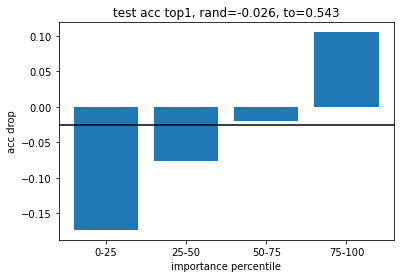

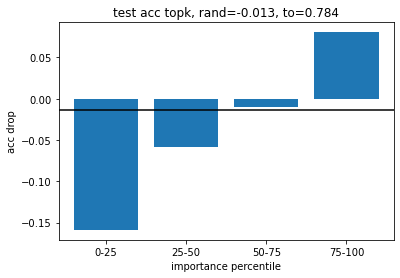

In [142]:
model_nickname = 'convnext_0.004'
from_epoch = 1
to_epoch = 3

agg_data = aggregate_eval_score(model_nickname, from_epoch, to_epoch, labels)
draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)

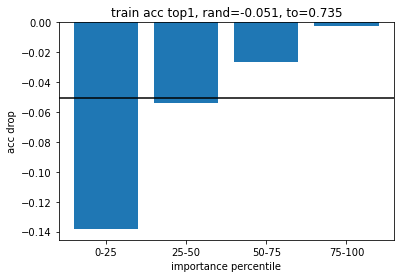

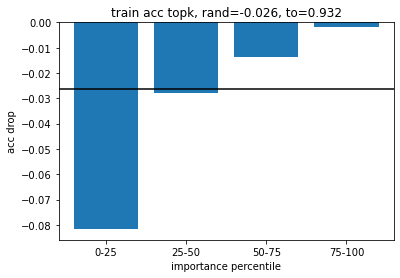

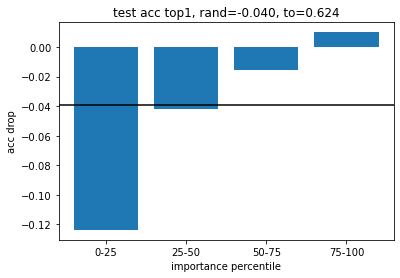

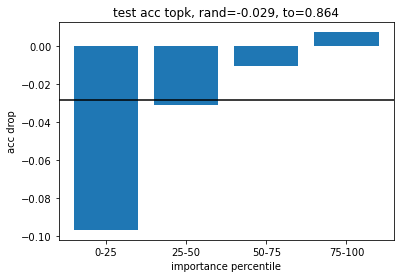

In [143]:
model_nickname = 'convnext_0.004'
from_epoch = 3 
to_epoch = 96

agg_data = aggregate_eval_score(model_nickname, from_epoch, to_epoch, labels)
draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)

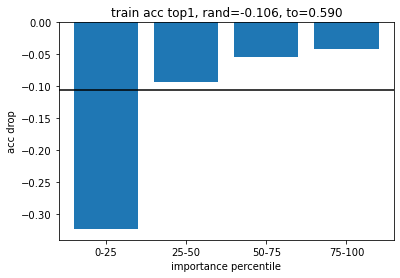

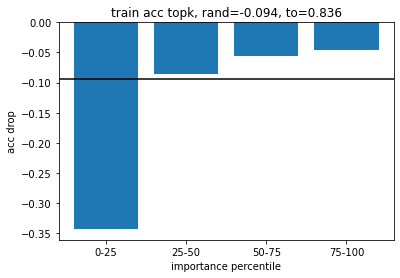

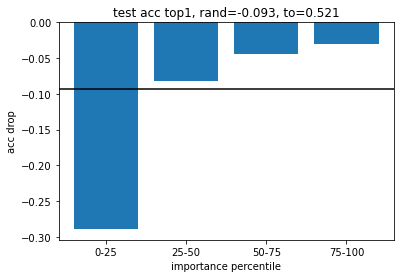

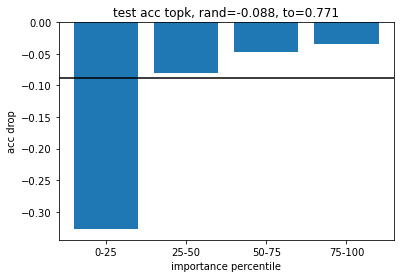

In [144]:
model_nickname = 'inception_v3_0.5'
from_epoch = 1
to_epoch = 11

agg_data = aggregate_eval_score(model_nickname, from_epoch, to_epoch, labels)
draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)

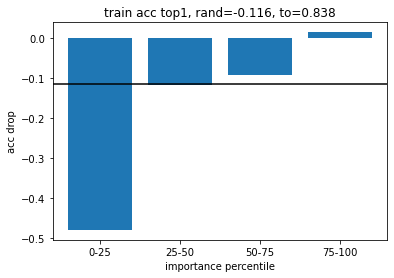

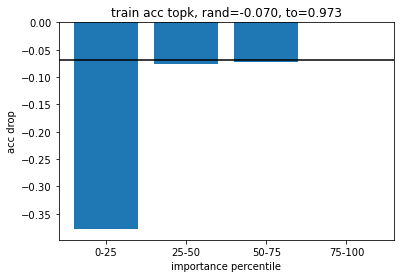

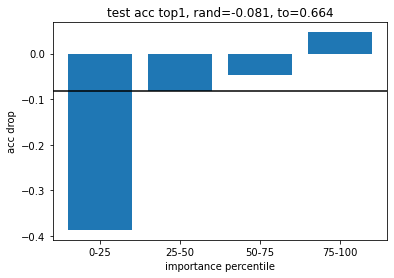

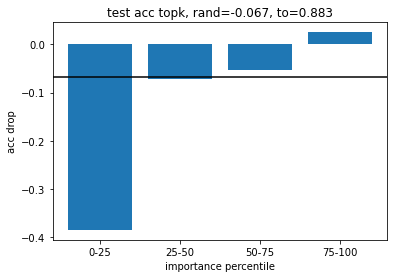

In [145]:
model_nickname = 'inception_v3_0.5'
from_epoch = 11
to_epoch = 121

agg_data = aggregate_eval_score(model_nickname, from_epoch, to_epoch, labels)
draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)

## VGG16
It has different format, so just creating the figure from the final summary

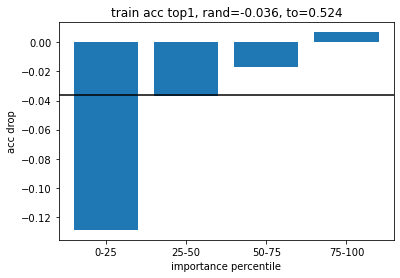

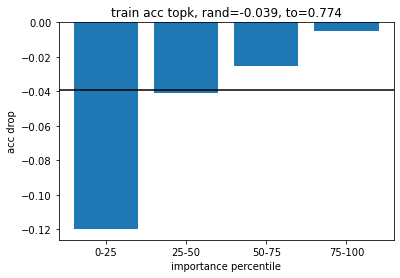

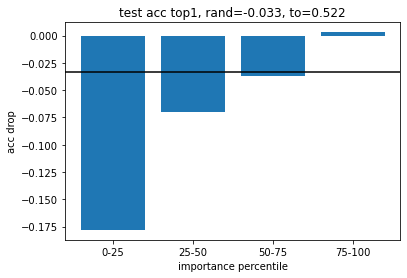

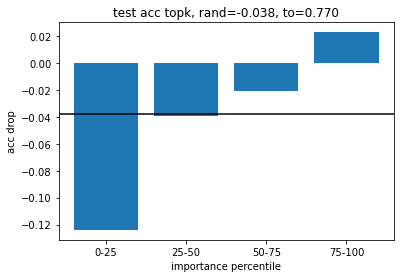

In [146]:
model_nickname = 'vgg16_0.01'
from_epoch = 5
to_epoch = 21

agg_data = {
    'train': {
        'important': {
            'top1': [-0.129, -0.037, -0.017, 0.007], 
            'topk': [-0.120, -0.041, -0.025, -0.005]
        },
        'random': {'top1': -0.036, 'topk': -0.039},
        'to': {'top1': 0.524, 'topk': 0.774}
    },
    'test': {
        'important': {
            'top1': [-0.178, -0.070, -0.037, 0.003], 
            'topk': [-0.124, -0.039, -0.021, 0.023]
        },
        'random': {'top1': -0.033, 'topk': -0.038},
        'to': {'top1': 0.522, 'topk': 0.770}
    }
}

draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)

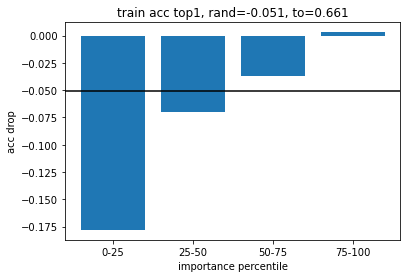

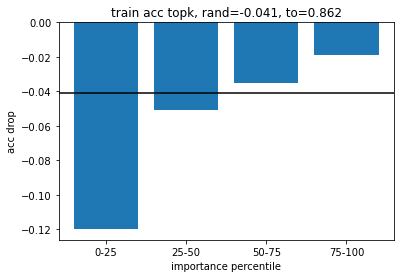

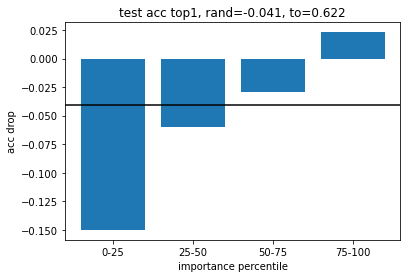

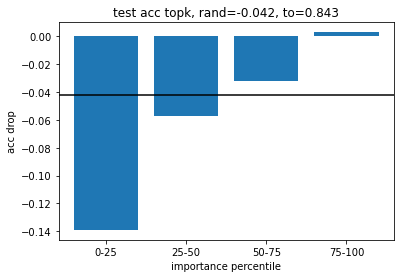

In [147]:
model_nickname = 'vgg16_0.01'
from_epoch = 21
to_epoch = 207

agg_data = {
    'train': {
        'important': {
            'top1': [-0.178, -0.070, -0.037, 0.003], 
            'topk': [-0.120, -0.051, -0.035, -0.019]
        },
        'random': {'top1': -0.051, 'topk': -0.041},
        'to': {'top1': 0.661, 'topk': 0.862}
    },
    'test': {
        'important': {
            'top1': [-0.150, -0.060, -0.029, 0.023], 
            'topk': [-0.139, -0.057, -0.032, 0.003]
        },
        'random': {'top1': -0.041, 'topk': -0.042},
        'to': {'top1': 0.622, 'topk': 0.843}
    }
}

draw_and_save_plot(agg_data, model_nickname, from_epoch, to_epoch, out_dir)

p = os.path.join(out_dir, f'{model_nickname}-{from_epoch}-{to_epoch}.json')
with open(p, 'w') as f:
    json.dump(agg_data, f)